In [1]:
import scipy
import numpy as np
import jax
import jaxopt
import jax.numpy as jnp

from functools import partial

from dtumpc.simulation import simulate_state_estimation
from dtumpc.models import default_params, disturbance_constant, sensor_stochastic, pidx
from dtumpc.linearize import linearize_system, discretize_system, augment_system
from dtumpc.plotting import plot_results
from dtumpc.qp import solve_qp
from dtumpc.kalman import kalman_filter_stationary, kalman_filter_dynamic, markov_parameters

In [2]:
key = jax.random.key(0)

In [3]:
from jaxopt.linear_solve import solve_cg

Q = 2 * jnp.array([[2.0, 0.5], [0.5, 1]])
c = jnp.array([1.0, 1.0])
matvec = lambda x: jnp.dot(Q, x)

sol = solve_cg(matvec, b=-c)

sol

Array([-0.14285713, -0.42857143], dtype=float32)

In [4]:
N = 64

I_N = np.eye(N)

# output weights
W_z = jnp.eye(2)

W_z_bar = jnp.kron(I_N, W_z)

W_z_bar

Array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [5]:
def compute_Gamma(H, N):
    """
    H: (N, n_out, n_in) with H[0]=H0, ..., H[N-1]=H_{N-1}
    Returns: (N*n_out, N*n_in)
    """
    _, ny, nu = H.shape
    
    i = jnp.arange(N)[:, None]   # row blocks
    j = jnp.arange(N)[None, :]   # col blocks
    k = i - j + 1                    # selects H_k

    mask = k >= 0
    k = jnp.clip(k, 0, N)

    blocks = H[k] * mask[..., None, None]

    return blocks.transpose(0, 2, 1, 3).reshape(N * ny, N * nu)

In [6]:
x_s = jnp.array([28661., 35865., 16304., 18970.])
u_s = jnp.array([200.0, 200.0])
d_s = jnp.array([300.0, 300.0])

setpoints = [x_s, u_s, d_s]

cont_sys = linearize_system(x_s, u_s, d_s, default_params)
disc_sys = discretize_system(cont_sys, 1)
sys = augment_system(disc_sys)

In [7]:
sys.C

Array([[0.00263066, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00263066, 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)

In [8]:
H = markov_parameters(sys.A, sys.B, sys.C, horizon=N)
Gamma = compute_Gamma(H, N)
Gamma

Array([[1.5195183e-03, 3.9952292e-06, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.5588866e-06, 1.8871215e-03, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.5070577e-03, 1.1884122e-05, 1.5195183e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.0522832e-04, 1.1956340e-03, 4.0222952e-04, ..., 1.8871215e-03,
        0.0000000e+00, 0.0000000e+00],
       [9.0451009e-04, 2.7832933e-04, 9.1198873e-04, ..., 1.1884122e-05,
        1.5195183e-03, 3.9952292e-06],
       [4.0814525e-04, 1.1868655e-03, 4.0522832e-04, ..., 1.8732814e-03,
        5.5588866e-06, 1.8871215e-03]], dtype=float32)

In [9]:
H_z = (W_z_bar @ Gamma).T @ (W_z_bar @ Gamma)
H_z

Array([[9.6937416e-05, 3.4728768e-05, 9.5286050e-05, ..., 1.5436789e-06,
        1.3766885e-06, 7.7383339e-07],
       [3.4728768e-05, 1.5102980e-04, 3.4177621e-05, ..., 4.4840522e-06,
        4.2952416e-07, 2.2408713e-06],
       [9.5286050e-05, 3.4177621e-05, 9.5952695e-05, ..., 1.5326746e-06,
        1.3880361e-06, 7.6835869e-07],
       ...,
       [1.5436789e-06, 4.4840522e-06, 1.5326746e-06, ..., 7.0705678e-06,
        2.8471499e-08, 3.5351570e-06],
       [1.3766885e-06, 4.2952416e-07, 1.3880361e-06, ..., 2.8471499e-08,
        2.3089669e-06, 1.6561119e-08],
       [7.7383339e-07, 2.2408713e-06, 7.6835869e-07, ..., 3.5351570e-06,
        1.6561119e-08, 3.5612434e-06]], dtype=float32)

In [11]:
M_z = -(W_z_bar @ Gamma).T @ W_z_bar
M_z

Array([[-1.5195183e-03, -5.5588866e-06, -1.5070577e-03, ...,
        -4.0522832e-04, -9.0451009e-04, -4.0814525e-04],
       [-3.9952292e-06, -1.8871215e-03, -1.1884122e-05, ...,
        -1.1956340e-03, -2.7832933e-04, -1.1868655e-03],
       [ 0.0000000e+00,  0.0000000e+00, -1.5195183e-03, ...,
        -4.0222952e-04, -9.1198873e-04, -4.0522832e-04],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.8871215e-03, -1.1884122e-05, -1.8732814e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -1.5195183e-03, -5.5588866e-06],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -3.9952292e-06, -1.8871215e-03]], dtype=float32)

In [12]:
def compute_Phis(sys, N):
    Phi_x = []
    Phi_w = []

    A_i = jnp.eye(sys.A.shape[0])

    for _ in range(N):
        Phi_w.append(sys.C @ A_i @ sys.G)
        A_i = A_i @ sys.A
        Phi_x.append(sys.C @ A_i)

    return jnp.vstack(Phi_x), jnp.vstack(Phi_w)

In [13]:
Phi_x, Phi_w = compute_Phis(sys, N)

In [14]:
Phi_x.round()

Array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0.

In [15]:
Phi_w.round()

Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

In [ ]:
@jax.jit
def mpc_unconstrained(t, x_hat, w_hat, setpoints, params, Phi_x, Phi_w, M_z, H_z, N_horizon):
    b_k = Phi_x @ x_hat + Phi_w @ w_hat

    c_k = setpoints - b_k
    
    g_z = M_z @ c_k

    matvec = lambda x: jnp.dot(H_z, x)

    sol = solve_cg(matvec, b=-g_z)

    #ones = jnp.ones_like(g_z)
    #lower = -jnp.inf * ones
    #upper = jnp.inf * ones
    #A = jnp.eye(g_z.shape[0])
    #sol = solve_qp(H_z, g_z, lower, upper, A, lower, upper)

    #print(t)
    #print("x_hat:", x_hat)
    #print("setpoints:", setpoints)
    #print("b_k:", b_k)
    #print("c_k:", c_k)
    #print("sol:", sol)
    #print()

    # return first control input
    return sol[:2]

(3664, 2)


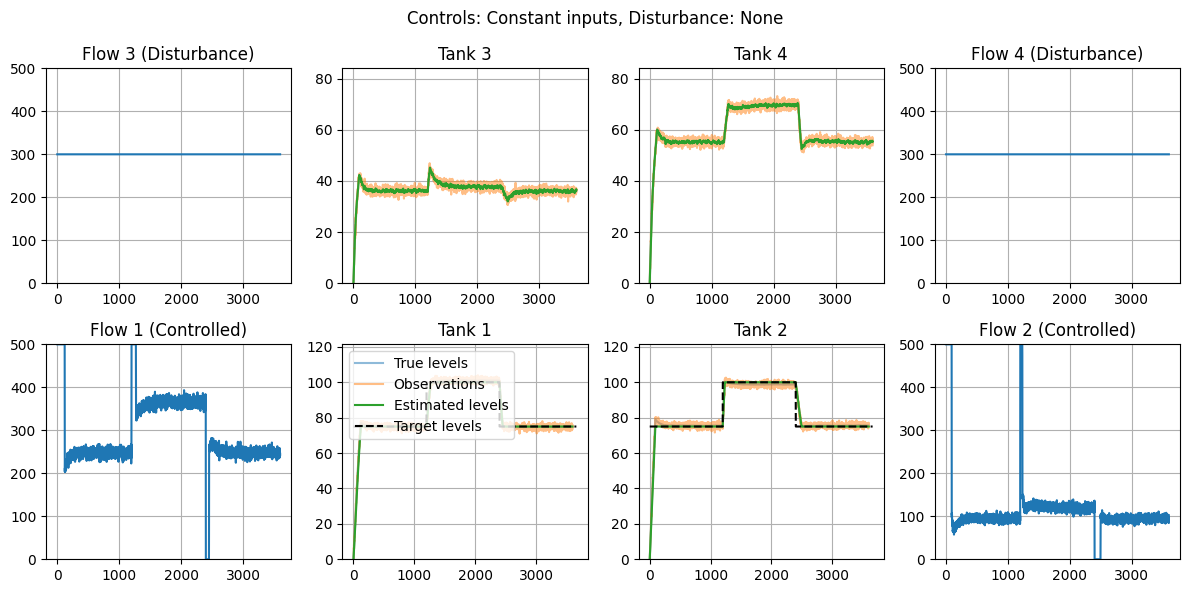

In [ ]:
key, subkey = jax.random.split(key)

setpoints_varying = jnp.vstack([
    jnp.ones((1200, 2)) * 75,
    jnp.ones((1200, 2)) * 100,
    jnp.ones((1200, 2)) * 75,
])

controller = partial(
    mpc_unconstrained,
    Phi_x=Phi_x,
    Phi_w=Phi_w,
    M_z=M_z,
    H_z=H_z,
    N_horizon=N,
)

disturbance = partial(disturbance_constant, value=d_s)

sensor = partial(sensor_stochastic, std=1)

Rww = jnp.array([
    [30.0, 0.0],
    [0.0, 20.0],
])

Rvv = jnp.eye(4)

Rwv = jnp.zeros((2, 4))

Q = sys.G @ Rww @ sys.G.T

estimator = partial(
    kalman_filter_dynamic,
    sys=sys,
    Rvv=Rvv,
    Rwv=Rwv,
    Q=Q,
)

initial_estimates = (
    np.concatenate([-x_s, np.zeros(2)]),
    np.zeros(2),
    np.eye(6),
)

def constant_input(t, x_hat, w_hat, setpoints, params):
    return jnp.ones(2) * 300

states, inputs, observations, estimations = simulate_state_estimation(
    controller,
    disturbance,
    sensor,
    estimator,
    initial_estimates,
    setpoints,
    setpoints_varying,
    N,
    default_params,
    subkey,
)

plot_results(
    states, 
    inputs, 
    "Constant inputs", 
    "None",
    observations=observations,
    estimations=estimations,
    targets=setpoints_varying,
)

In [18]:
K = 100
states[K:K+100, 0]

Array([67.2764  , 67.79134 , 68.30099 , 68.80538 , 69.30461 , 69.798805,
       70.287926, 70.77215 , 71.251465, 71.725914, 72.19552 , 72.66036 ,
       73.1204  , 73.57573 , 74.02639 , 74.47256 , 74.91424 , 75.35153 ,
       75.78445 , 76.21298 , 76.637184, 77.05712 , 77.07747 , 77.04993 ,
       77.011536, 76.98605 , 76.94747 , 76.94402 , 76.924194, 76.90998 ,
       76.90071 , 76.86911 , 76.82725 , 76.79298 , 76.77383 , 76.74913 ,
       76.71587 , 76.70858 , 76.692085, 76.67997 , 76.675896, 76.65675 ,
       76.64245 , 76.60244 , 76.59744 , 76.5783  , 76.55695 , 76.52893 ,
       76.49742 , 76.46279 , 76.43541 , 76.41731 , 76.40074 , 76.37261 ,
       76.35726 , 76.340126, 76.3282  , 76.321884, 76.3061  , 76.28233 ,
       76.2896  , 76.263084, 76.25998 , 76.24591 , 76.256615, 76.25858 ,
       76.24362 , 76.23715 , 76.23196 , 76.2286  , 76.229744, 76.20201 ,
       76.17357 , 76.158195, 76.15122 , 76.14017 , 76.12266 , 76.10615 ,
       76.083626, 76.067696, 76.04542 , 75.999535, 

In [19]:
test = setpoints_varying[::200]

test.reshape(-1)

Array([ 75.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,
        75., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,
        75.,  75.,  75.,  75.,  75.], dtype=float32)